Optimisation de la distribution (logits) de noise2

In [29]:
# Cellule 1 : Imports et données
import functions
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D
import os

device = 'cpu'  # passer à 'cuda' si dispo
torch.manual_seed(42)

# Chemins
SAVE_DIR = r"C:\Users\gauti\OneDrive\Documents\UE D recherche\UE_D_Recherche\code"
LOGITS_FILENAME = "optimized_logits_c2.pt"
SAVE_PATH = os.path.join(SAVE_DIR, LOGITS_FILENAME)
os.makedirs(SAVE_DIR, exist_ok=True)

# Données cibles
try:
    data = np.load("Train_TurbModane_N65536_sampling4_Nreal256_v3.npz")
    S2_target = torch.from_numpy(data['S2'].mean(axis=0)).float().to(device)
    flatness_target = torch.from_numpy(data['Flat'].mean(axis=0)).float().to(device)
    scales = torch.from_numpy(data["scales"]).float().to(device)
    print("Données cibles chargées.")
except FileNotFoundError:
    print("Erreur : fichier .npz introuvable")

Données cibles chargées.


In [30]:
# Cellule 2 : Modèle et logits

# Hyperparamètres
tN = 2**16
M = 1
alpha_loss = 0.3
beta_loss = 1.0
gamma_loss = 0.3

# Paramètres optimisables
c1_opt = torch.tensor(0.36, requires_grad=True, device=device)
c2_opt = torch.tensor(0.02, requires_grad=True, device=device)
delta_sigma_opt = torch.tensor(1.0, requires_grad=False, device=device)
h_mu_opt = torch.tensor(0.0, device=device)
h_sigma_opt = torch.tensor(1.0, device=device)

# Histogramme (loi apprise)
n_bins = 300
bin_centers = torch.linspace(-6.0, 6.0, n_bins, device=device)

# Chargement / init des logits
if os.path.exists(SAVE_PATH):
    print(f"Fichier trouvé : {SAVE_PATH}\nChargement des logits...")
    loaded_logits = torch.load(SAVE_PATH, map_location=device)
    logits_opt = torch.tensor(loaded_logits, requires_grad=True, device=device)
else:
    print(f"Aucun fichier trouvé à {SAVE_PATH}\nInit gaussienne.")
    init_log_probs = D.Normal(0, 1).log_prob(bin_centers)
    logits_opt = torch.tensor(init_log_probs, requires_grad=True, device=device)

# Stabilisation
temperature = 2.0
smoothness_weight = 0.5

# Bruits fixes
base_noise1 = torch.randn(M, int(tN), device=device)
fixed_uniform = torch.rand(M, int(tN), n_bins, device=device)
fixed_gumbel_noise = -torch.log(-torch.log(fixed_uniform + 1e-9) + 1e-9)

optimizer = torch.optim.Adam([
    {'params': [logits_opt], 'lr': 0.001}
])

print("Modèle prêt.")

Fichier trouvé : C:\Users\gauti\OneDrive\Documents\UE D recherche\UE_D_Recherche\code\optimized_logits_c2.pt
Chargement des logits...
Modèle prêt.


C:\Users\gauti\AppData\Local\Temp\ipykernel_2388\899339260.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_opt = torch.tensor(loaded_logits, requires_grad=True, device=device)


In [31]:
# Cellule 3 : Boucle d'optimisation
num_epochs = 100
loss_history, c2_history = [], []

print("Démarrage de l'optimisation...")

try:
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # 1. Gumbel-Softmax -> noise2
        current_logits = logits_opt.view(1, 1, -1).expand(M, int(tN), n_bins)
        y_soft = F.softmax((current_logits + fixed_gumbel_noise) / temperature, dim=-1)
        noise2_raw = torch.sum(y_soft * bin_centers, dim=-1)
        noise2 = (noise2_raw - noise2_raw.mean(dim=1, keepdim=True)) / (noise2_raw.std(dim=1, keepdim=True) + 1e-8)

        # 2. Synthèse MRW
        noise1 = base_noise1 * h_sigma_opt + h_mu_opt
        MRW = delta_sigma_opt * functions.synthMRWregul_Torch(
            noise1, noise2, int(tN), c1_opt, c2_opt, np.exp(8), epsilon=1.0, win=1
        )

        # 3. Loss physique
        MRW_reshaped = torch.reshape(MRW, (-1, 2**16))
        moments = functions.analyseIncrsTorchcuda(MRW_reshaped, scales, device='cpu')
        S2_sim = torch.exp(moments[:, 0, :]).mean(dim=0)
        flat_sim = moments[:, 2, :].mean(dim=0)

        mse_lin_s2 = F.mse_loss(S2_sim, S2_target)
        mse_log_s2 = F.mse_loss(torch.log(S2_sim + 1e-10), torch.log(S2_target + 1e-10))
        loss_S2 = alpha_loss * mse_lin_s2 + (1 - alpha_loss) * mse_log_s2

        mse_lin_flat = F.mse_loss(flat_sim, flatness_target)
        mse_log_flat = F.mse_loss(torch.log(flat_sim + 1e-10), torch.log(flatness_target + 1e-10))
        loss_Flat = beta_loss * mse_lin_flat + (1 - beta_loss) * mse_log_flat

        loss_phy = gamma_loss * loss_S2 + (1 - gamma_loss) * loss_Flat * 1000

        # 4. Régularisation (lissage des logits)
        diff_logits = logits_opt[1:] - logits_opt[:-1]
        loss_smooth = torch.sum(torch.abs(diff_logits))

        loss = loss_phy + smoothness_weight * loss_smooth
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        c2_history.append(c2_opt.item())

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f} | loss_phy: {loss_phy.item():.4f} | loss_smooth: {loss_smooth.item():.4f} | c1: {c1_opt.item():.4f} | c2: {c2_opt.item():.4f}")

except KeyboardInterrupt:
    print("Interruption manuelle. Sauvegarde...")

print(f"Sauvegarde des logits dans : {SAVE_PATH}")
torch.save(logits_opt.detach(), SAVE_PATH)
print("Sauvegarde terminée.")

Démarrage de l'optimisation...


Epoch 5/100 | Loss: 17.9407 | loss_phy: 1.0345 | loss_smooth: 33.8124 | c1: 0.3600 | c2: 0.0200
Epoch 10/100 | Loss: 17.9211 | loss_phy: 1.0384 | loss_smooth: 33.7655 | c1: 0.3600 | c2: 0.0200
Epoch 10/100 | Loss: 17.9211 | loss_phy: 1.0384 | loss_smooth: 33.7655 | c1: 0.3600 | c2: 0.0200
Epoch 15/100 | Loss: 17.9116 | loss_phy: 1.0396 | loss_smooth: 33.7439 | c1: 0.3600 | c2: 0.0200
Epoch 15/100 | Loss: 17.9116 | loss_phy: 1.0396 | loss_smooth: 33.7439 | c1: 0.3600 | c2: 0.0200
Epoch 20/100 | Loss: 17.9071 | loss_phy: 1.0399 | loss_smooth: 33.7344 | c1: 0.3600 | c2: 0.0200
Epoch 20/100 | Loss: 17.9071 | loss_phy: 1.0399 | loss_smooth: 33.7344 | c1: 0.3600 | c2: 0.0200
Epoch 25/100 | Loss: 17.9033 | loss_phy: 1.0403 | loss_smooth: 33.7261 | c1: 0.3600 | c2: 0.0200
Epoch 25/100 | Loss: 17.9033 | loss_phy: 1.0403 | loss_smooth: 33.7261 | c1: 0.3600 | c2: 0.0200
Epoch 30/100 | Loss: 17.9011 | loss_phy: 1.0399 | loss_smooth: 33.7225 | c1: 0.3600 | c2: 0.0200
Epoch 30/100 | Loss: 17.9011 | 

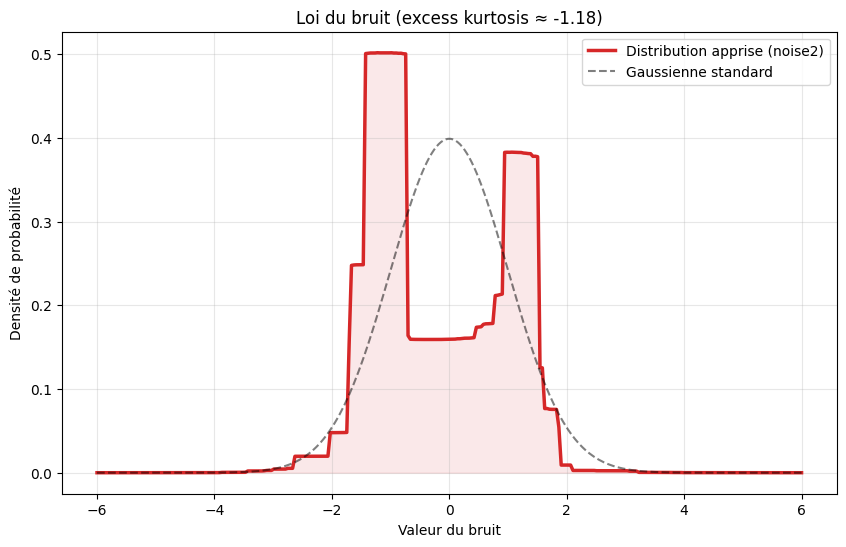

Génération d'un échantillon de validation...


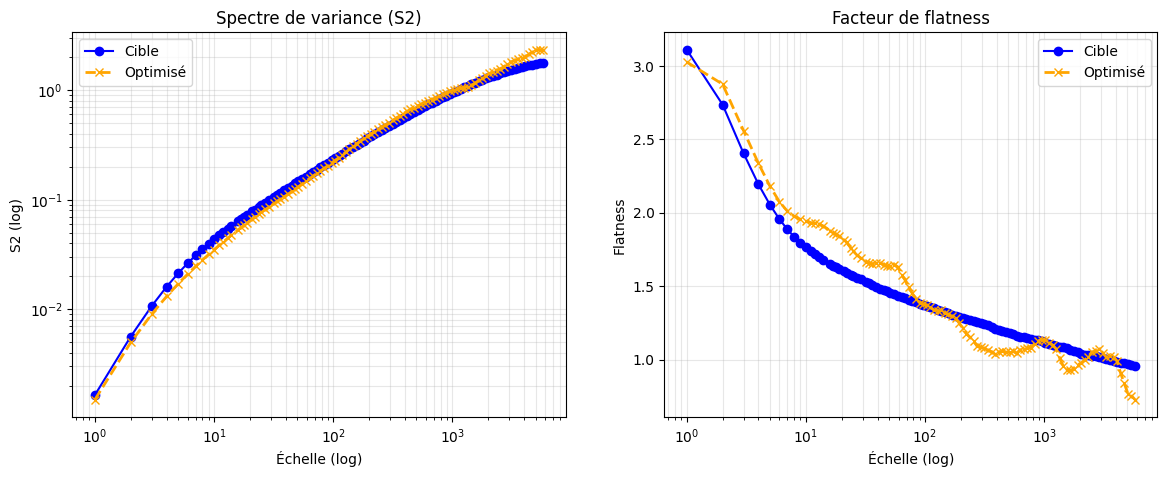

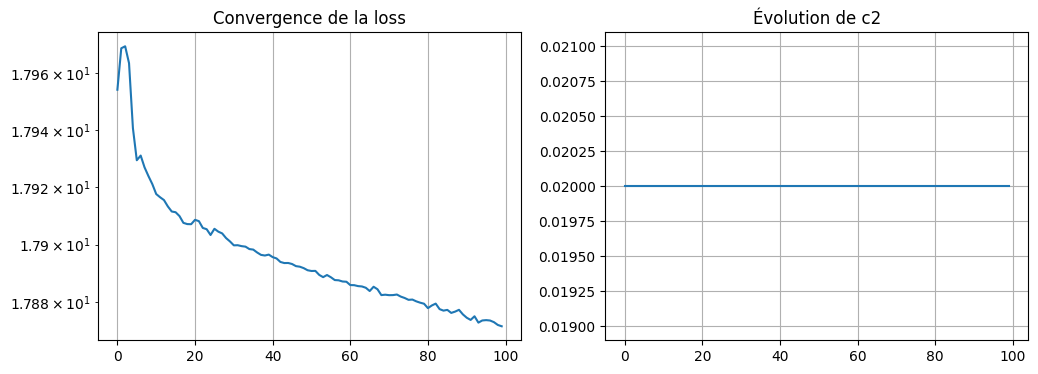

In [32]:
# Cellule 4 : Analyse et visualisation
plt.style.use('default')

# 1) Loi apprise vs gaussienne
with torch.no_grad():
    x_axis = bin_centers.cpu().numpy()
    dx = x_axis[1] - x_axis[0]
    learned_probs = F.softmax(logits_opt, dim=0).cpu().numpy()
    learned_density = learned_probs / dx
    ref_density = torch.exp(D.Normal(0, 1).log_prob(bin_centers)).cpu().numpy()

    mean_dist = np.sum(x_axis * learned_probs)
    var_dist = np.sum(((x_axis - mean_dist)**2) * learned_probs)
    kurt_dist = np.sum(((x_axis - mean_dist)**4) * learned_probs) / (var_dist**2)
    excess_kurtosis = kurt_dist - 3

plt.figure(figsize=(10, 6))
plt.plot(x_axis, learned_density, label='Distribution apprise (noise2)', color='#d62728', linewidth=2.5)
plt.plot(x_axis, ref_density, '--', label='Gaussienne standard', color='black', alpha=0.5)
plt.fill_between(x_axis, learned_density, alpha=0.1, color='#d62728')
plt.title(f"Loi du bruit (excess kurtosis ≈ {excess_kurtosis:.2f})")
plt.xlabel("Valeur du bruit")
plt.ylabel("Densité de probabilité")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# 2) Vérification physique avec un échantillon de validation
print("Génération d'un échantillon de validation...")
with torch.no_grad():
    current_logits = logits_opt.view(1, 1, -1).expand(M, int(tN), n_bins)
    random_uniform = torch.rand_like(fixed_uniform)
    random_gumbel = -torch.log(-torch.log(random_uniform + 1e-9) + 1e-9)
    y_soft = F.softmax((current_logits + random_gumbel) / temperature, dim=-1)
    noise2_raw = torch.sum(y_soft * bin_centers, dim=-1)
    noise2_final = (noise2_raw - noise2_raw.mean(dim=1, keepdim=True)) / (noise2_raw.std(dim=1, keepdim=True) + 1e-8)

    noise1 = base_noise1 * h_sigma_opt + h_mu_opt
    MRW_final = delta_sigma_opt * functions.synthMRWregul_Torch(
        noise1, noise2_final, int(tN), c1_opt, c2_opt, np.exp(8), epsilon=1.0, win=1
    )

    MRW_reshaped = torch.reshape(MRW_final, (-1, 2**16))
    moments_final = functions.analyseIncrsTorchcuda(MRW_reshaped, scales, device='cpu')
    S2_optim = torch.exp(moments_final[:, 0, :]).mean(dim=0).cpu().numpy()
    flat_optim = moments_final[:, 2, :].mean(dim=0).cpu().numpy()

scales_np = scales.cpu().numpy()
s2_target_np = S2_target.cpu().numpy()
flat_target_np = flatness_target.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.loglog(scales_np, s2_target_np, 'o-', label='Cible', color='blue')
ax1.loglog(scales_np, S2_optim, 'x--', label='Optimisé', color='orange', linewidth=2)
ax1.set_xlabel("Échelle (log)"); ax1.set_ylabel("S2 (log)"); ax1.set_title("Spectre de variance (S2)")
ax1.legend(); ax1.grid(True, which="both", alpha=0.3)

ax2.semilogx(scales_np, flat_target_np, 'o-', label='Cible', color='blue')
ax2.semilogx(scales_np, flat_optim, 'x--', label='Optimisé', color='orange', linewidth=2)
ax2.set_xlabel("Échelle (log)"); ax2.set_ylabel("Flatness"); ax2.set_title("Facteur de flatness")
ax2.legend(); ax2.grid(True, which="both", alpha=0.3)
plt.show()

# 3) Historique d'apprentissage
if len(loss_history) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(loss_history); ax1.set_title("Convergence de la loss"); ax1.set_yscale("log"); ax1.grid(True)
    ax2.plot(c2_history); ax2.set_title("Évolution de c2"); ax2.grid(True)
    plt.show()
else:
    print("Pas d'historique en mémoire (modèle chargé).")

Génération du signal (N=1048576) et calcul des histogrammes...


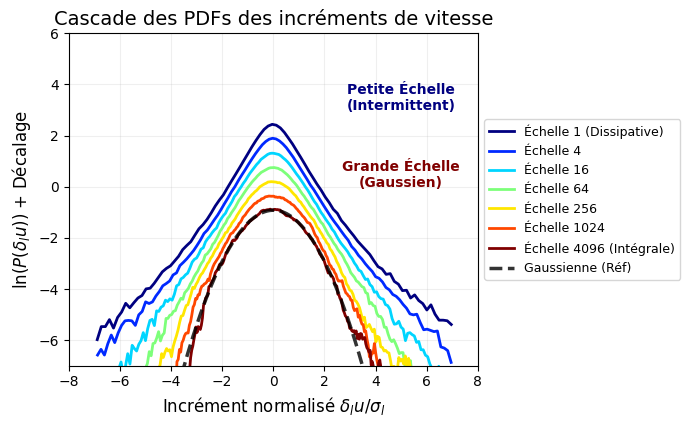

In [34]:
# Cellule 5 : Visualisation de la Cascade des PDFs (Style Chevillard)

import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# --- Paramètres de visualisation ---
N_visu = 2**20          # Taille du signal pour une bonne statistique
list_scales_idx = [1, 4, 16, 64, 256, 1024, 4096] # Échelles à tracer
vertical_shift_step = 0.5 # Décalage vertical entre les courbes
plot_limit = 7          # Limites des données tracées (x)
x_limit = 8             # Limites de l'axe x
y_limit = 6             # Limites de l'axe y

print(f"Génération du signal (N={N_visu}) et calcul des histogrammes...")

# --- 1. Synthèse du signal MRW ---
with torch.no_grad():
    # Génération du bruit d'intermittence (noise2) via Gumbel-Softmax
    current_logits = logits_opt.view(1, 1, -1).expand(M, int(N_visu), n_bins)
    random_uniform = torch.rand(M, int(N_visu), n_bins, device=device)
    random_gumbel = -torch.log(-torch.log(random_uniform + 1e-9) + 1e-9)
    y_soft = F.softmax((current_logits + random_gumbel) / temperature, dim=-1)
    
    noise2_visu = torch.sum(y_soft * bin_centers, dim=-1)
    # Normalisation
    noise2_visu = (noise2_visu - noise2_visu.mean(dim=1, keepdim=True)) / (noise2_visu.std(dim=1, keepdim=True) + 1e-8)
    
    # Bruit gaussien corrélé (noise1)
    noise1_visu = (torch.randn(M, int(N_visu), device=device) * h_sigma_opt + h_mu_opt)
    
    # Synthèse MRW
    MRW_visu = delta_sigma_opt * functions.synthMRWregul_Torch(
        noise1_visu, noise2_visu, int(N_visu), c1_opt, c2_opt, np.exp(8), epsilon=1.0, win=1
    )
    signal = MRW_visu.cpu().numpy().flatten()

# --- 2. Tracé des PDFs ---
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal', adjustable='box') # Grille carrée
colors = cm.jet(np.linspace(0, 1, len(list_scales_idx)))

for i, lag in enumerate(list_scales_idx):
    if lag >= len(signal): break
    
    # Calcul des incréments normalisés
    incrs = signal[lag:] - signal[:-lag]
    incrs = (incrs - np.mean(incrs)) / (np.std(incrs) + 1e-10)
    
    # Histogramme (PDF)
    hist, bin_edges = np.histogram(incrs, bins=200, density=True)
    bin_centers_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
    log_pdf = np.log(hist + 1e-20)
    
    # Décalage vertical pour la cascade (les petites échelles en haut)
    shift = (len(list_scales_idx) - 1 - i) * vertical_shift_step
    
    # Masque pour l'affichage (limites et seuil de densité)
    mask = (log_pdf > -20) & (np.abs(bin_centers_plot) <= plot_limit)
    
    # Légende dynamique
    label_txt = f"Échelle {lag}"
    if i == 0: label_txt += " (Dissipative)"
    elif i == len(list_scales_idx)-1: label_txt += " (Intégrale)"
        
    ax.plot(bin_centers_plot[mask], log_pdf[mask] + shift, 
             color=colors[i], lw=2, label=label_txt)

# --- 3. Référence Gaussienne et Mise en forme ---
x_ref = np.linspace(-plot_limit, plot_limit, 200)
log_gaussian = -0.5 * np.log(2 * np.pi) - 0.5 * x_ref**2
ax.plot(x_ref, log_gaussian, 'k--', lw=2.5, alpha=0.8, label='Gaussienne (Réf)')

ax.set_title("Cascade des PDFs des incréments de vitesse", fontsize=14)
ax.set_xlabel(r"Incrément normalisé $\delta_l u / \sigma_l$", fontsize=12)
ax.set_ylabel(r"$\ln(P(\delta_l u))$ + Décalage", fontsize=12)

# Limites des axes (Grille carrée visuellement)
ax.set_xlim(-x_limit, x_limit) 
ax.set_ylim(-y_limit - 1, y_limit)

# Annotations
top_pos = (len(list_scales_idx) - 1) * vertical_shift_step
ax.text(5, 0, "Grande Échelle\n(Gaussien)", fontsize=10, ha='center', color=colors[-1], fontweight='bold')
ax.text(5, top_pos, "Petite Échelle\n(Intermittent)", fontsize=10, ha='center', color=colors[0], fontweight='bold')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax.grid(True, alpha=0.2, which='both')
plt.tight_layout()
plt.show()